In [1]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
import FinanceDataReader as fdr
warnings.filterwarnings('ignore')


In [94]:
fdr.StockListing('KRX')

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,65500,1,900,1.39,65200,65900,65000,19699481,1288159418828,391020757025000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,581000,2,-6000,-1.02,590000,591000,573000,316880,183868381000,135954000000000,234000000,STK
2,000660,KR7000660001,SK하이닉스,KOSPI,,89500,1,700,0.79,90800,91400,88700,3737493,336529892700,65156211667500,728002365,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,781000,1,3000,0.39,775000,787000,775000,51554,40277366000,55586894000000,71174000,STK
4,051910,KR7051910008,LG화학,KOSPI,,740000,2,-1000,-0.13,746000,750000,730000,257164,189764736000,52238333820000,70592343,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,245450,KR7245450002,씨앤에스링크,KONEX,일반기업부,1780,2,-1,-0.06,0,0,0,0,0,2812328800,1579960,KNX
2709,000547,KR7000542001,흥국화재2우B,KOSPI,,16840,3,0,0.00,16850,16850,16750,901,15170740,2586624000,153600,STK
2710,288490,KR7288490006,나라소프트,KONEX,일반기업부,62,1,3,5.08,59,63,55,64711,3819379,2365114000,38147000,KNX
2711,308700,KR7308700004,테크엔,KONEX,일반기업부,380,2,-47,-11.01,491,491,363,468,181327,1520000000,4000000,KNX


## 삼성전자 변동성 예측

In [95]:
stock = '005930'
df = fdr.DataReader(stock, '2016-01-01')

In [96]:
df.head(10)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-01-04,25200,25200,24100,24100,306939,-0.043651
2016-01-05,24040,24360,23720,24160,216002,0.002490
2016-01-06,24160,24160,23360,23500,366752,-0.027318
2016-01-07,23320,23660,23020,23260,282388,-0.010213
2016-01-08,23260,23720,23260,23420,257763,0.006879
2016-01-11,23120,23320,22920,23040,241277,-0.016225
2016-01-12,22960,23320,22880,22920,206283,-0.005208
2016-01-13,23060,23180,22960,22960,143316,0.001745
2016-01-14,22620,22840,22620,22760,209022,-0.008711


In [97]:
# ret 변동성 (단위: 퍼센트)
ret = 100 * (df.pct_change()[1:]['Close'])
ret


Date
2016-01-05    0.248963
2016-01-06   -2.731788
2016-01-07   -1.021277
2016-01-08    0.687876
2016-01-11   -1.622545
                ...   
2023-04-24   -0.761035
2023-04-25   -2.453988
2023-04-26    0.786164
2023-04-27    0.780031
2023-04-28    1.393189
Name: Close, Length: 1802, dtype: float64

In [98]:
# n 값 구하기 
len(ret) - len(ret) * 0.8

360.39999999999986

In [99]:
n = 360 

In [100]:
# 이동 표준편차 (5일)
realized_vol = ret.rolling(5).std()

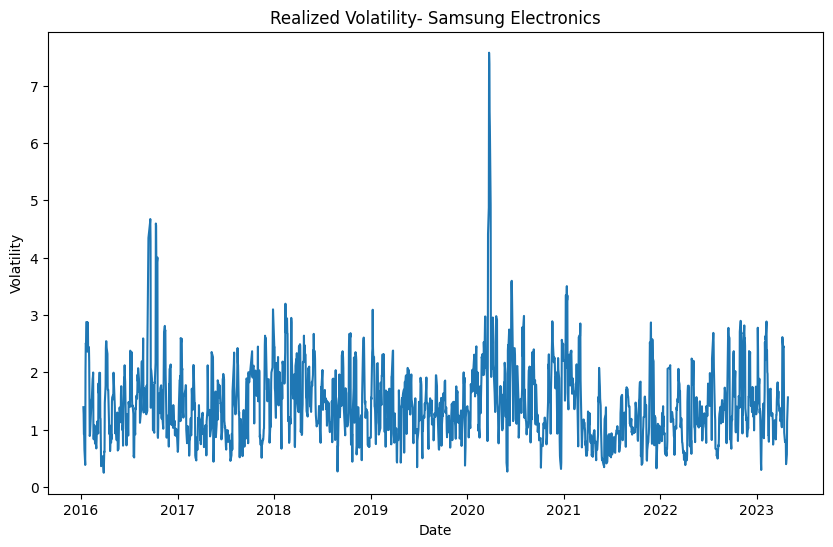

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- Samsung Electronics')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

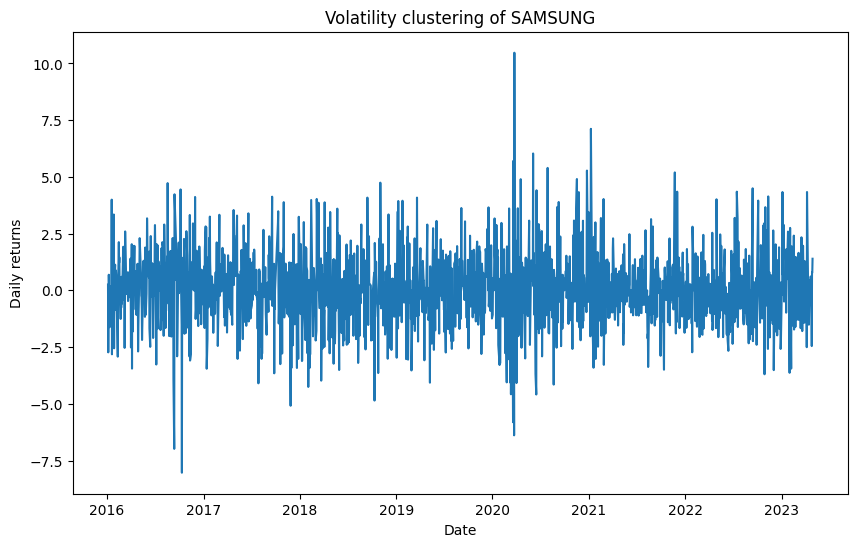

In [102]:
# 변동성 그래프 
plt.figure(figsize=(10, 6))
plt.plot(df.index[1:], ret)
plt.title('Volatility clustering of SAMSUNG')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show()

In [105]:
# 파라미터 정의 - 5일 이동표준편차 저장
realized_vol = ret.rolling(5).std()

# 데이터 프레임 생성 
realized_vol = pd.DataFrame(realized_vol)

# 데이터 프레임 인덱스 제거
realized_vol.reset_index(drop=True, inplace=True)


In [106]:
# 변동성 제곱한 변수 생성
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

In [107]:
# 위 두 변수 합치기 
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)

# 이동평균에 의해 생성된 NAN 값 제거 
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [109]:
# Null 값 제거 
realized_vol = realized_vol.dropna().reset_index()

# index 컬럼 삭제 
realized_vol.drop('index', axis=1, inplace=True)

# 다시 date 적용 
realized_vol.index = ret.iloc[4:].index

In [110]:
# 딥러닝 모델 라이브러리 불러오기 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [111]:
# 모델 파라미터 설정 
model = keras.Sequential(
        [layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="linear"),])



In [112]:
# RMSProp은 이전 그래디언트(gradient)의 제곱값에 대한 지수 가중 이동 평균을 사용하여 학습률을 조정
model.compile(loss='mse', optimizer='rmsprop') 

In [113]:
len(X)

1798

In [114]:
len(X.iloc[:-n].values)

1438

In [115]:
realized_vol.iloc[1:-(n-1)].values.reshape(-1,)

array([1.27052464, 0.9206624 , 0.90000783, ..., 0.77632235, 0.77613373,
       0.87919794])

In [116]:
epochs_trial = np.arange(100, 400, 4) 
batch_trial = np.arange(100, 400, 4) 
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):

# 위에 정의한 n개에 따라서 X_train과 X_test(실제 변동률)을 나눠서 fit함 
    model.fit(X.iloc[:-n].values,
            realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
            batch_size=k, epochs=j, verbose=False)
# epoch, batch 경우에 따라서 저장 
    DL_predict = model.predict(np.asarray(X.iloc[-n:])) 
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))



12/12 [==============================] - 0s 2ms/step
DL_RMSE_4:0.001645


In [117]:
# RMSE 점수가 가장 낮을 값의 예측을 출력 
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index



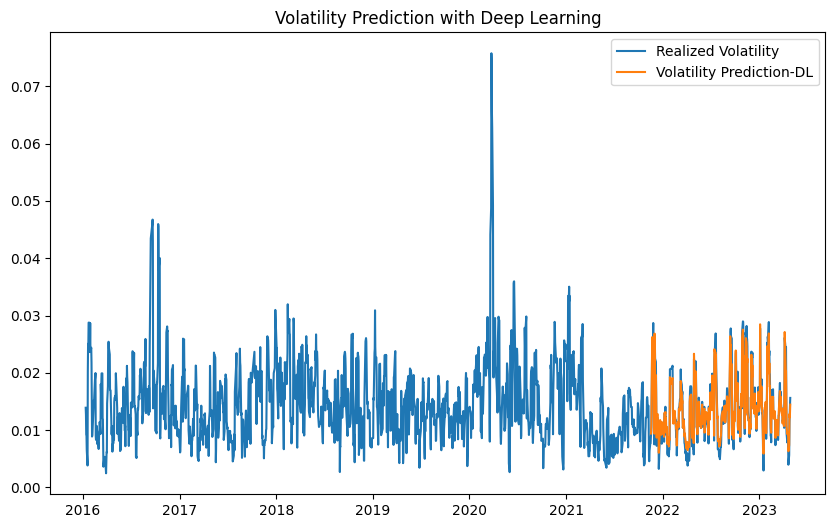

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()